In [96]:
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import matplotlib.patches as mpatches
from lifelines.utils import concordance_index
import scipy
from scipy import stats
from scipy.stats import linregress
from scipy.special import gamma
from scipy.cluster.hierarchy import linkage, cophenet, dendrogram, fcluster
from scipy.spatial.distance import pdist
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering

fontsize = 14
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
legend_size =14
plt.rc('font', size=MEDIUM_SIZE)  # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)

font = {'family': 'normal',
        'weight': 'bold',
        'size': 24}

plt.rc('font', **font)
params = {'legend.fontsize': 'x-large',
          # 'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize': 'x-large',
          'xtick.labelsize': 'x-large',
          'ytick.labelsize': 'x-large'}

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

plt.rcParams.update(params)
import seaborn as sns
import pandas
sns.set_style('white')
sns.set_context('paper')
sns.set()
seed=31415
np.random.seed(seed)

In [97]:
#
model = 'CSA-INFO'
is_non_param = True
is_stochastic = True

if 'SR' in model:
    is_stochastic = False
    
if 'AFT' in model:
    is_non_param = False      
    
data = 'framingham'

if data =='framingham':
    alpha = "01"
else:
    alpha = '0'

if alpha:
    main_path = 'analysis/{}/alpha_{}/'.format(data, alpha)
    path = 'analysis/{}/alpha_{}/{}/'.format(data, alpha, model)
else:
    path = 'analysis/{}/{}/'.format(data, model)
    main_path = 'analysis/{}/'.format(data)


#data = 'sythentic'
#path = 'analysis/{}/alpha_{}/{}/'.format(fld,alpha,  model)

print(path)
has_cf = True
if 'simulated' in data:
    time = 'days'
    is_simulated = True
else:
    is_simulated = False
    time = 'days'
if is_non_param:
    pred_t0_f = np.load(path + 'Test_pred_t0_F.npy')
    pred_t0_cf = np.load(path +  'Test_pred_t0_CF.npy')

    pred_t1_f = np.load(path +  'Test_pred_t1_F.npy')
    pred_t1_cf = np.load(path +  'Test_pred_t1_CF.npy')
    print("pred_t0_f: ", pred_t0_f.shape)
    print("pred_t0_cf: ", pred_t0_cf.shape)

    print("pred_t1_f: ", pred_t1_f.shape)
    print("pred_t1_cf: ", pred_t1_cf.shape)
    
    pred_c0_f = np.load(path + 'Test_pred_c0_F.npy')
    pred_c0_cf = np.load(path +  'Test_pred_c0_CF.npy')

    pred_c1_f = np.load(path +  'Test_pred_c1_F.npy')
    pred_c1_cf = np.load(path +  'Test_pred_c1_CF.npy')
    
    print("pred_c0_f: ", pred_c0_f.shape)
    print("pred_c0_cf: ", pred_c0_cf.shape)

    print("pred_c1_f: ", pred_c1_f.shape)
    print("pred_c1_cf: ", pred_c1_cf.shape)
    
else:
    pred_t0_f = pandas.read_csv(path + 'Test_pred_t0_F.csv')
    pred_t0_cf = pandas.read_csv(path +  'Test_pred_t0_CF.csv')

    pred_t1_f = pandas.read_csv(path +  'Test_pred_t1_F.csv')
    pred_t1_cf = pandas.read_csv(path +  'Test_pred_t1_CF.csv')
    
    print("pred_t0_f: ", pred_t0_f.shape,pred_t0_f.head())
    print("pred_t0_cf: ", pred_t0_cf.shape, pred_t0_cf.head())

    print("pred_t1_f: ", pred_t1_f.shape, pred_t1_f.head())
    print("pred_t1_cf: ", pred_t1_cf.shape, pred_t1_cf.head())



analysis/framingham/alpha_01/CSA-INFO/
pred_t0_f:  (455, 200)
pred_t0_cf:  (60, 200)
pred_t1_f:  (60, 200)
pred_t1_cf:  (455, 200)
pred_c0_f:  (455, 200)
pred_c0_cf:  (60, 200)
pred_c1_f:  (60, 200)
pred_c1_cf:  (455, 200)


In [98]:
if data == 'framingham':
    covariates = ['age6', 'age61', 'age62', 'ascvd_hx6', 'bmi6', 'bmi61', 'bmi62', 'bpmeds6',
                  'chol5', 'chol51', 'chol52', 'dbp6', 'dbp61', 'dbp62', 'diab6', 'female',
                  'gluc5', 'gluc51', 'gluc52', 'hdl5', 'hdl51', 'hdl52',
                  'pad_hx6', 'sbp6', 'sbp61', 'sbp62', 'smoke6', 'stk_hx6', 'mi_hx6',
                  'trigly5', 'trigly51', 'trigly52']

    print("covariates: ", len(covariates))

    sub_covariates = ['age6', 'ascvd_hx6', 'bmi6', 'bpmeds6','chol5', 'dbp6', 'diab6', 'female', 'gluc5',  'hdl5', 
                  'pad_hx6', 'sbp6', 'smoke6', 'stk_hx6', 'mi_hx6',  'trigly5']

    print("sub_covariates", len(sub_covariates))
else:
    covariates =  ['age', 'wtkg', 'hemo', 'homo', 'drugs', 'karnof', 'oprior','z30', 'zprior',
                   'preanti', 'race', 'gender', 'str2', 'strat','symptom', 'treat', 'offtrt', 
                   'cd40', 'cd420', 'cd496', 'r', 'cd80','cd820']
    print("covariates: ", len(covariates))
    
    sub_covariates = covariates

covariates:  32
sub_covariates 16


In [99]:
if is_simulated:
    dir_path = 'data/{}/'.format(data)
    path_factual =  dir_path + 'event_pairs.csv' 
    path_covariates = dir_path +  'covariates.npy'
    path_treatment = dir_path + 'treatment.npy'
    print("path:{}".format(path_factual))
    data_frame = pandas.read_csv(path_factual)
    print("head of data:{}, data shape:{}".format(data_frame.head(), data_frame.shape))

    idx = np.load(dir_path + 'test_idx.npy')

    # Preprocess
    a = np.load(path_treatment)[idx]

    ## Factual
    y_f = data_frame[['y_f']]
    e_f = data_frame[['e_f']]
    t_f = data_frame[['t_f']]

    y_f = np.array(y_f).reshape(len(y_f))[idx]
    e_f = np.array(e_f).reshape(len(e_f))[idx]
    t_f = np.array(t_f).reshape(len(t_f))[idx]

    ## Counter Factual
    y_cf = data_frame[['y_cf']]
    e_cf = data_frame[['e_cf']]
    t_cf = data_frame[['t_cf']]

    y_cf = np.array(y_cf).reshape(len(y_cf))[idx]
    e_cf = np.array(e_cf).reshape(len(e_cf))[idx]
    t_cf = np.array(t_cf).reshape(len(t_cf))[idx]

    print("a: ", a.shape)

    print("y_cf: ", y_cf.shape)
    print("e_cf: ", e_cf.shape)
    print("t_cf: ", t_cf.shape)


    print("y_f: ", y_f.shape)
    print("e_f: ", e_f.shape)
    print("t_f: ", t_f.shape)

else:
    path_factual = 'data/{}/{}_test_idx.csv'.format(data, data)
    data_frame = pandas.read_csv(path_factual)
    ## Factual
    y_f = data_frame[['time']]
    e_f = data_frame[['event']]
    a = data_frame[['treatment']]
    x = data_frame[covariates]
    
    y_f = np.array(y_f).reshape(len(y_f))
    e_f = np.array(e_f).reshape(len(e_f))
    a = np.array(a).reshape(len(a))
    
    ## Counter Factual
    y_cf = data_frame[['nn_cf_y']]
    e_cf = data_frame[['nn_cf_e']]
 

    y_cf = np.array(y_cf).reshape(len(y_cf))
    e_cf = np.array(e_cf).reshape(len(e_cf))
    
    
    print("a: ", a.shape)
    
    print("y_cf: ", y_cf.shape)
    print("e_cf: ", e_cf.shape)

    print("y_f: ", y_f.shape)
    print("e_f: ", e_f.shape)
    print("a=1", np.sum(a))
    print("y_f[a==1.0].shape", y_f[a==1].shape)
    print("x: ", x.shape)
  
    

    




a:  (515,)
y_cf:  (515,)
e_cf:  (515,)
y_f:  (515,)
e_f:  (515,)
a=1 60.0
y_f[a==1.0].shape (60,)
x:  (515, 32)


In [100]:
def hr_dist(hr, ms):
    perc_50 = np.round(np.percentile(hr, 50),2)
    perc_2_5 = np.round(np.percentile(hr, 2.5),2)
    perc_97_5 = np.round(np.percentile(hr, 97.5),2)
    print(ms, "{} ({}, {})".format(perc_50, perc_2_5, perc_97_5))
    

In [101]:
def compute_grad(surv, time):
    slope, intercept, r_value, p_value, std_err = linregress(x=time, y=surv) # 
    #print("slope: ", slope, "std_err: ", std_err)
    
    #gradient = [(y2-y0)/(x2-x0) for x2, x0, y2, y0 in zip(time[2:], time, surv[2:], surv)]
    

    return  slope
    

# Causal Metrics

In [102]:

# T_0_pred #pred_t0_f, pred_t0_cf
# T_1_pred # pred_t1_f, pred_t1_cf

T_0_pred = np.concatenate((pred_t0_f, pred_t0_cf), axis=0)
T_1_pred = np.concatenate((pred_t1_cf,pred_t1_f), axis=0)

print("T_0_pred: ", T_0_pred.shape)
print("T_1_pred: ", T_1_pred.shape)
print("pred_t0_f: ", pred_t0_f.shape, "pred_t1_cf: ", pred_t1_cf.shape)
print("pred_t1_f: ", pred_t1_f.shape, "pred_t0_cf: ", pred_t0_cf.shape )
    

x_0 = x.iloc[a==0]
x_1 = x.iloc[a==1]

print(x_0.shape)
print(x_1.shape)

x0_x1_conc = pandas.concat([x_0, x_1], axis=0)

print(x0_x1_conc.shape)

zero = np.array([0])
all_t_range = np.concatenate((zero, np.sort(y_f)))
print("all_t_range: ", all_t_range.shape)

T_0_pred:  (515, 200)
T_1_pred:  (515, 200)
pred_t0_f:  (455, 200) pred_t1_cf:  (455, 200)
pred_t1_f:  (60, 200) pred_t0_cf:  (60, 200)
(455, 32)
(60, 32)
(515, 32)
all_t_range:  (516,)


In [103]:
x_0.describe()

,age6,age61,age62,ascvd_hx6,bmi6,bmi61,bmi62,bpmeds6,chol5,chol51,...,pad_hx6,sbp6,sbp61,sbp62,smoke6,stk_hx6,mi_hx6,trigly5,trigly51,trigly52
count,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,...,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000,455.000000
mean,57.650549,7.005656,1.094300,0.083516,27.836624,2.551863,0.507544,0.257143,202.338462,20.669323,...,0.013187,127.369231,10.467159,1.931534,0.193407,0.024176,0.032967,144.261538,30.468226,11.491322
std,9.594583,8.983994,1.965585,0.276966,5.097342,4.287990,1.174040,0.437540,33.118659,29.014455,...,0.114200,18.309741,15.490517,3.913355,0.395404,0.153764,0.178747,96.985919,71.851921,31.109896
min,35.000000,0.000000,0.000000,0.000000,17.676632,0.000000,0.000000,0.000000,105.000000,0.000000,...,0.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.000000,0.000000,0.000000
25%,51.000000,0.532778,0.000000,0.000000,24.342611,0.130127,0.000000,0.000000,180.000000,1.784340,...,0.000000,114.000000,0.480000,0.000000,0.000000,0.000000,0.000000,83.000000,0.244709,0.000000
50%,56.000000,2.286160,0.008325,0.000000,27.235345,0.859652,0.016579,0.000000,201.000000,9.211875,...,0.000000,126.000000,3.840000,0.060000,0.000000,0.000000,0.000000,120.000000,3.481385,0.111383
75%,65.000000,11.056664,1.369880,0.000000,30.549053,3.053826,0.419032,1.000000,221.500000,26.452390,...,0.000000,138.000000,12.921905,1.593333,0.000000,0.000000,0.000000,164.500000,18.200893,4.027889
max,84.000000,46.451613,11.425598,1.000000,49.154229,28.365909,8.197843,1.000000,311.000000,168.866667,...,1.000000,189.000000,90.133333,24.663333,1.000000,1.000000,1.000000,813.000000,670.626866,298.601790


In [104]:
x_1.describe()

,age6,age61,age62,ascvd_hx6,bmi6,bmi61,bmi62,bpmeds6,chol5,chol51,...,pad_hx6,sbp6,sbp61,sbp62,smoke6,stk_hx6,mi_hx6,trigly5,trigly51,trigly52
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,...,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,64.150000,12.930808,2.320905,0.316667,28.993009,2.976886,0.552253,0.633333,233.650000,56.843871,...,0.100000,131.266667,13.767726,2.836248,0.166667,0.066667,0.133333,200.016667,62.346172,24.433698
std,8.313406,10.740757,2.537664,0.469102,4.397932,3.337312,0.864667,0.485961,45.367361,54.002275,...,0.302532,20.984956,23.428731,6.461287,0.375823,0.251549,0.342803,149.939817,139.867447,62.606721
min,49.000000,0.224766,0.000000,0.000000,19.285225,0.000000,0.000000,0.000000,125.000000,0.000000,...,0.000000,102.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67.000000,0.000000,0.000000
25%,56.750000,2.713059,0.023153,0.000000,26.688324,0.653533,0.005135,0.000000,203.750000,11.106476,...,0.000000,117.000000,0.937500,0.000000,0.000000,0.000000,0.000000,109.000000,2.162470,0.017379
50%,65.500000,11.819128,1.558462,0.000000,29.242462,1.981591,0.175769,1.000000,230.500000,37.201621,...,0.000000,127.500000,4.611250,0.118750,0.000000,0.000000,0.000000,172.500000,22.308789,5.523850
75%,71.000000,21.341406,4.143695,1.000000,31.914649,4.429522,0.782845,1.000000,266.250000,92.793687,...,0.000000,140.250000,15.403571,2.206562,0.000000,0.000000,0.000000,227.000000,60.695171,21.358363
max,77.000000,32.903226,7.492196,1.000000,39.183163,14.135882,3.743467,1.000000,327.000000,196.066667,...,1.000000,214.000000,130.133333,36.913333,1.000000,1.000000,1.000000,1149.000000,1024.179104,459.645453


## Estimate Hazard

Text(0.5, 0, 'Time (days)')

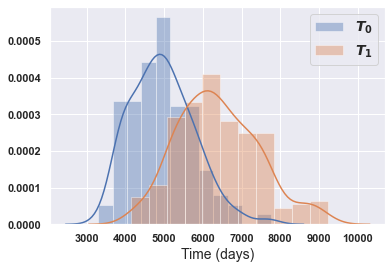

In [105]:
ex_i = 100
# 250 = negative, 500 = positive , 400 = neutral for framingham
# 90 = negative,  3=positive,  100=neutral actg175
sns.distplot(T_0_pred[ex_i], label='$T_0$')
sns.distplot(T_1_pred[ex_i], label='$T_1$')
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)


Text(0.5, 0, 'Time (days)')

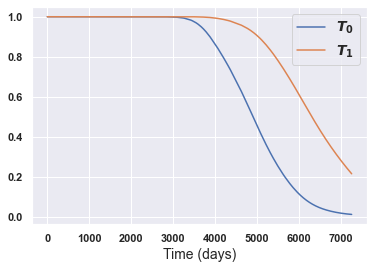

In [106]:
#t_emp_range = np.sort(np.concatenate((T_0_pred[ex_i], T_1_pred[ex_i]), axis=0))
t_emp_range = all_t_range
kernel_t0 = stats.gaussian_kde(T_0_pred[ex_i]) 
kernel_t1 = stats.gaussian_kde(T_1_pred[ex_i]) 

surv_t0  = []
surv_t1  = []
#print(np.sort(T_0_pred[1]))
for i in t_emp_range:
    surv_t0.append(1-kernel_t0.integrate_box_1d(low=0, high=i))
    surv_t1.append(1-kernel_t1.integrate_box_1d(low=0, high=i))
    
surv_t0 = np.array(surv_t0)
surv_t1 = np.array(surv_t1)

plt.plot(t_emp_range, surv_t0, label='$T_0$')
plt.plot(t_emp_range, surv_t1, label='$T_1$')
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)

CSA-INFO mean: HR EST Slope  -2.43 (-3.27, -0.35)


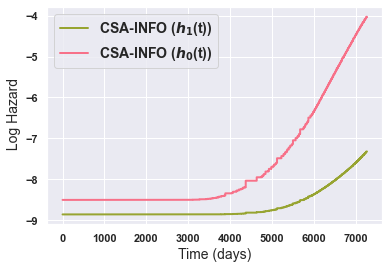

<Figure size 432x288 with 0 Axes>

In [107]:
s_0_prime_est = compute_grad(surv=surv_t0, time=t_emp_range)  
s_1_prime_est = compute_grad(surv=surv_t1, time=t_emp_range)


constant = 1e-8
surv_ratio = (surv_t0 + constant)/ (surv_t1 + constant)
surv_prime_ratio = (s_1_prime_est + constant )/(s_0_prime_est + constant)
HR_est_slope=  np.log(surv_ratio * surv_prime_ratio)
hr_dist(HR_est_slope, model + " mean: HR EST Slope ")

colors = sns.color_palette("husl", 4)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel(" Log Hazard",  fontsize=fontsize)

plt.step(t_emp_range, np.log(-s_1_prime_est / surv_t1),  label=model+' ($h_1$(t))', lw=2,
         color=colors[1])
plt.step(t_emp_range, np.log(-s_0_prime_est / surv_t0),  label=model+' ($h_0$(t))', lw=2,
        color=colors[0])


plt.legend(loc='best', fontsize=legend_size)
plt.show()
plt.tight_layout()




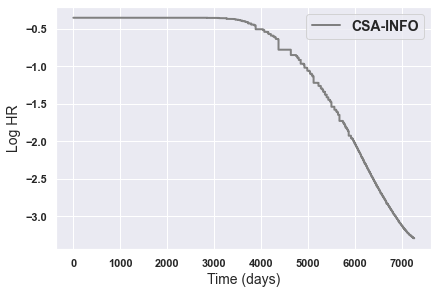

In [108]:
plt.step(t_emp_range, HR_est_slope, label=model, lw=2, color='grey')
plt.tight_layout()
plt.legend(loc='best', fontsize=legend_size)
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel("Log HR",  fontsize=fontsize)
plt.show()


In [109]:
def compute_hr (t0_pred_i, t1_pred_i):
    #t_emp_range = np.sort(np.concatenate((t0_pred_i, t1_pred_i), axis=0))

    kernel_t0 = stats.gaussian_kde(t0_pred_i) 
    kernel_t1 = stats.gaussian_kde(t1_pred_i) 

    surv_t0  = []
    surv_t1  = []

    for i in all_t_range:
        surv_t0.append(1-kernel_t0.integrate_box_1d(low=0, high=i))
        surv_t1.append(1-kernel_t1.integrate_box_1d(low=0, high=i))
    
    surv_t0 = np.array(surv_t0)
    surv_t1 = np.array(surv_t1)
    
    s_0_prime_est = compute_grad(surv=surv_t0, time=t_emp_range)
    
    s_1_prime_est = compute_grad(surv=surv_t1, time=t_emp_range)

    #HR_est_slope= surv_t0/surv_t1 * (s_1_prime_est /s_0_prime_est)
    constant = 1e-8
    surv_ratio = surv_t0 / surv_t1
    surv_prime_ratio = s_1_prime_est / s_0_prime_est 
    HR_est_slope=  np.log( surv_ratio  *  surv_prime_ratio + constant)
    
    return HR_est_slope


In [110]:
all_HR = []
all_HR_median = []
for i in np.arange(T_0_pred.shape[0]):
    hr = compute_hr(t0_pred_i=T_0_pred[i], t1_pred_i=T_1_pred[i])
    all_HR_median.append(np.median(hr))
    all_HR.append(hr)


In [111]:
all_HR = np.array(all_HR)
all_HR_median = np.array(all_HR_median)

## Median Covariates  Statistics

In [112]:
print("positive: ", len(all_HR_median[all_HR_median < 0 ])/ len(all_HR_median))
pos_median = x0_x1_conc[all_HR_median < 0]

positive:  0.6893203883495146


In [113]:
pos_median[sub_covariates].describe()

,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000,355.000000
mean,57.535211,0.101408,28.535491,0.312676,209.070423,76.504225,0.121127,0.487324,103.008451,46.171831,0.014085,127.839437,0.188732,0.022535,0.039437,162.659155
std,9.138963,0.302295,4.778960,0.464238,38.343056,8.671458,0.326735,0.500545,34.024541,12.163031,0.118006,17.504628,0.391848,0.148626,0.194906,91.827395
min,35.000000,0.000000,19.285225,0.000000,105.000000,53.000000,0.000000,0.000000,66.000000,16.000000,0.000000,91.000000,0.000000,0.000000,0.000000,38.000000
25%,51.000000,0.000000,25.284703,0.000000,181.000000,70.000000,0.000000,0.000000,90.000000,37.000000,0.000000,115.000000,0.000000,0.000000,0.000000,101.000000
50%,56.000000,0.000000,28.021534,0.000000,204.000000,76.000000,0.000000,0.000000,95.000000,45.000000,0.000000,125.000000,0.000000,0.000000,0.000000,140.000000
75%,64.000000,0.000000,30.888693,1.000000,232.000000,82.000000,0.000000,1.000000,103.000000,53.000000,0.000000,138.000000,0.000000,0.000000,0.000000,197.500000
max,84.000000,1.000000,49.154229,1.000000,327.000000,105.000000,1.000000,1.000000,315.000000,95.000000,1.000000,192.000000,1.000000,1.000000,1.000000,813.000000


In [114]:
print("negative", len(all_HR_median[all_HR_median > 0])/ len(all_HR_median))
neg_median = x0_x1_conc[all_HR_median>0]

negative 0.3106796116504854


In [115]:
neg_median[sub_covariates].describe()

,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000
mean,60.343750,0.131250,26.719658,0.275000,199.143750,71.881250,0.056250,0.575000,96.712500,57.337500,0.043750,127.787500,0.193750,0.043750,0.056250,124.350000
std,10.543141,0.338734,5.355192,0.447916,29.679387,11.176329,0.231127,0.495895,19.212937,15.802988,0.205181,21.059779,0.396476,0.205181,0.231127,128.238732
min,35.000000,0.000000,17.676632,0.000000,118.000000,49.000000,0.000000,0.000000,48.000000,22.000000,0.000000,88.000000,0.000000,0.000000,0.000000,33.000000
25%,53.000000,0.000000,22.988095,0.000000,180.000000,63.000000,0.000000,0.000000,89.000000,47.000000,0.000000,111.000000,0.000000,0.000000,0.000000,65.750000
50%,60.500000,0.000000,25.768858,0.000000,199.500000,70.000000,0.000000,1.000000,95.000000,58.000000,0.000000,127.000000,0.000000,0.000000,0.000000,89.000000
75%,69.000000,0.000000,29.605862,1.000000,219.250000,81.000000,0.000000,1.000000,101.000000,67.000000,0.000000,139.000000,0.000000,0.000000,0.000000,119.250000
max,80.000000,1.000000,45.992112,1.000000,298.000000,105.000000,1.000000,1.000000,239.000000,101.000000,1.000000,214.000000,1.000000,1.000000,1.000000,1149.000000


In [116]:
print("neutral", len(all_HR_median[all_HR_median == 0])/ len(all_HR_median))

neutral 0.0


## Cluster Map

In [117]:
linkage_data = linkage(all_HR, 'ward')
c, coph_dists = cophenet(linkage_data, pdist(all_HR))
print("preserved_distance:{}".format(c))



preserved_distance:0.6062902891662171


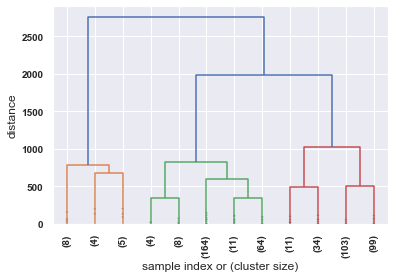

In [118]:

plt.figure()
    # plt.title('{} Hierarchical Clustering Dendrogram'.format(name), fontsize=title_fontsize)
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
        linkage_data,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=12,  # show only the last p merged clusters
        leaf_rotation=90.,
        leaf_font_size=12,
        show_contracted=True,  # to get a distribution impression in truncated branches
    )
plt.tick_params(axis='both', which='major', labelsize=10)

/Users/paidamoyochapfuwa/.pyenv/versions/3.6.4/envs/csa_prod/lib/python3.6/site-packages/seaborn/matrix.py:624: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


<Figure size 360x288 with 0 Axes>

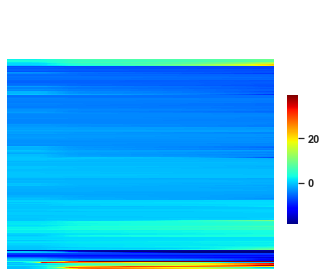

In [119]:
fig =plt.figure(figsize=(5,4))
g=sns.clustermap(all_HR,  cmap="jet", metric= 'euclidean', figsize=(5, 4),
                   yticklabels=False, xticklabels=False, col_cluster=False)
g.cax.set_position([1, .2, .03, .45])
g.ax_row_dendrogram.set_visible(False) 

In [120]:
if data == 'framingham':
    num_clusters = 4
else:
     num_clusters = 2
clusters = fcluster(linkage_data, num_clusters, criterion='maxclust')
print("clusters: ", clusters.shape, np.unique(clusters))


clusters:  (515,) [1 2 3 4]


c = 1  hr_c:  (17, 516)
c = 2  hr_c:  (251, 516)
c = 3  hr_c:  (45, 516)
c = 4  hr_c:  (202, 516)


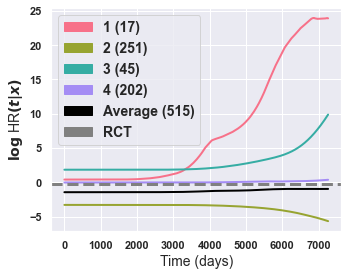

In [121]:
fig=plt.figure(figsize=(5,4))
model_colors = sns.color_palette("husl", num_clusters)
handles = []
for i in np.unique(clusters):
    idx = clusters == i
    hr_c = all_HR[idx]
    print('c =', i, " hr_c: ", hr_c.shape)
    mean_hr_c =  np.mean(hr_c, axis=0)
    handles.append(mpatches.Patch(color=model_colors[i-1], label="{} ({})".format(i, len(hr_c))))
    plt.plot(all_t_range, mean_hr_c, c=model_colors[i-1], linewidth=2)

handles.append(mpatches.Patch(color='black', label="{} ({})".format('Average', len(all_HR))))
handles.append(mpatches.Patch(color='grey', label="RCT"))
plt.plot(all_t_range, np.mean(all_HR, axis=0), c='black', linewidth=2)
plt.axhline(y= np.log(0.75), color='grey', label='mean', linestyle='--', lw=3)
ylabel =  '$\log$'  + ' ' +  'HR' + '$(t|x)$'    
plt.xlabel("Time ({})".format(time),  fontsize=fontsize)
plt.ylabel(ylabel ,  fontsize=fontsize)
plt.tight_layout()
#plt.legend(handles=handles, fontsize=legend_size, bbox_to_anchor=(0.95,1.05))
plt.legend(handles=handles, fontsize=legend_size, loc='best')

In [122]:
c1_cov = x0_x1_conc[clusters==1]
c1_cov[sub_covariates].describe()

,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.0,17.000000,17.000000
mean,66.941176,0.352941,30.911996,0.647059,199.235294,78.058824,0.117647,0.352941,97.235294,45.764706,0.117647,140.647059,0.176471,0.0,0.235294,228.588235
std,8.613003,0.492592,7.949390,0.492592,19.501697,12.577115,0.332106,0.492592,19.350483,18.081515,0.332106,13.181147,0.392953,0.0,0.437237,193.054739
min,51.000000,0.000000,22.343918,0.000000,169.000000,61.000000,0.000000,0.000000,48.000000,22.000000,0.000000,121.000000,0.000000,0.0,0.000000,48.000000
25%,59.000000,0.000000,23.869369,0.000000,190.000000,68.000000,0.000000,0.000000,90.000000,30.000000,0.000000,133.000000,0.000000,0.0,0.000000,79.000000
50%,71.000000,0.000000,28.261316,1.000000,196.000000,75.000000,0.000000,0.000000,94.000000,40.000000,0.000000,140.000000,0.000000,0.0,0.000000,119.000000
75%,74.000000,1.000000,33.377669,1.000000,204.000000,87.000000,0.000000,1.000000,105.000000,60.000000,0.000000,146.000000,0.000000,0.0,0.000000,323.000000
max,76.000000,1.000000,45.992112,1.000000,244.000000,98.000000,1.000000,1.000000,145.000000,84.000000,1.000000,180.000000,1.000000,0.0,1.000000,678.000000


In [123]:
c2_cov = x0_x1_conc[clusters==2]
c2_cov[sub_covariates].describe()

,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000,251.000000
mean,56.944223,0.091633,28.601880,0.338645,207.741036,77.250996,0.119522,0.454183,101.737052,45.254980,0.007968,127.820717,0.171315,0.023904,0.035857,165.131474
std,9.039739,0.289084,4.381290,0.474195,40.415649,8.204678,0.325050,0.498891,29.466499,11.956535,0.089086,16.472879,0.377537,0.153057,0.186304,91.672300
min,35.000000,0.000000,19.632587,0.000000,105.000000,55.000000,0.000000,0.000000,75.000000,16.000000,0.000000,98.000000,0.000000,0.000000,0.000000,38.000000
25%,51.000000,0.000000,25.647857,0.000000,180.000000,71.000000,0.000000,0.000000,90.000000,36.000000,0.000000,116.000000,0.000000,0.000000,0.000000,112.500000
50%,55.000000,0.000000,28.249814,0.000000,202.000000,77.000000,0.000000,0.000000,95.000000,44.000000,0.000000,126.000000,0.000000,0.000000,0.000000,142.000000
75%,63.500000,0.000000,31.033133,1.000000,228.500000,82.000000,0.000000,1.000000,104.000000,52.500000,0.000000,137.000000,0.000000,0.000000,0.000000,199.000000
max,84.000000,1.000000,45.135681,1.000000,327.000000,102.000000,1.000000,1.000000,289.000000,95.000000,1.000000,192.000000,1.000000,1.000000,1.000000,813.000000


In [124]:
c3_cov = x0_x1_conc[clusters==3]
c3_cov[sub_covariates].describe()

,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,45.000000,45.000000,45.000000,45.00000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000,45.000000
mean,58.088889,0.133333,25.281231,0.20000,199.200000,70.088889,0.044444,0.688889,94.555556,64.088889,0.044444,125.022222,0.244444,0.066667,0.066667,110.866667
std,10.175332,0.343776,4.455141,0.40452,27.682945,11.745061,0.208409,0.468179,11.073218,16.697608,0.208409,18.288706,0.434613,0.252262,0.252262,169.896840
min,37.000000,0.000000,18.191485,0.00000,137.000000,49.000000,0.000000,0.000000,77.000000,27.000000,0.000000,94.000000,0.000000,0.000000,0.000000,33.000000
25%,50.000000,0.000000,22.238275,0.00000,180.000000,61.000000,0.000000,0.000000,86.000000,54.000000,0.000000,111.000000,0.000000,0.000000,0.000000,59.000000
50%,57.000000,0.000000,24.541343,0.00000,198.000000,67.000000,0.000000,1.000000,95.000000,64.000000,0.000000,122.000000,0.000000,0.000000,0.000000,78.000000
75%,67.000000,0.000000,28.241633,0.00000,212.000000,77.000000,0.000000,1.000000,101.000000,79.000000,0.000000,138.000000,0.000000,0.000000,0.000000,91.000000
max,77.000000,1.000000,39.148276,1.00000,290.000000,97.000000,1.000000,1.000000,132.000000,101.000000,1.000000,165.000000,1.000000,1.000000,1.000000,1149.000000


In [125]:
c4_cov = x0_x1_conc[clusters==4]
c4_cov[sub_covariates].describe()

,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.000000,202.00000,202.000000,202.000000,202.000000
mean,59.579208,0.108911,27.539670,0.247525,205.886139,73.212871,0.089109,0.564356,101.970297,52.198020,0.029703,127.371287,0.20297,0.029703,0.034653,135.232673
std,9.945431,0.312301,5.332181,0.432646,33.052828,10.036710,0.285609,0.497073,34.697687,13.529419,0.170188,21.214746,0.40321,0.170188,0.183355,86.938077
min,35.000000,0.000000,17.676632,0.000000,118.000000,50.000000,0.000000,0.000000,66.000000,22.000000,0.000000,88.000000,0.00000,0.000000,0.000000,40.000000
25%,53.000000,0.000000,23.929236,0.000000,183.000000,66.000000,0.000000,0.000000,89.000000,42.000000,0.000000,112.000000,0.00000,0.000000,0.000000,80.250000
50%,60.000000,0.000000,26.505319,0.000000,205.500000,71.500000,0.000000,1.000000,95.000000,51.000000,0.000000,124.500000,0.00000,0.000000,0.000000,103.000000
75%,67.750000,0.000000,30.300379,0.000000,226.000000,80.750000,0.000000,1.000000,100.000000,61.000000,0.000000,138.750000,0.00000,0.000000,0.000000,163.250000
max,80.000000,1.000000,49.154229,1.000000,298.000000,105.000000,1.000000,1.000000,315.000000,99.000000,1.000000,214.000000,1.00000,1.000000,1.000000,525.000000


# TSNE

In [126]:
perp=50
tsne = TSNE(random_state=seed, perplexity=perp, verbose=1, n_components=2, init='pca', n_iter=5000)
tsne_all_HR = tsne.fit_transform(all_HR)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 515 samples in 0.000s...
[t-SNE] Computed neighbors for 515 samples in 0.020s...
[t-SNE] Computed conditional probabilities for sample 515 / 515
[t-SNE] Mean sigma: 8.792211
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.170387
[t-SNE] KL divergence after 4100 iterations: 0.227719


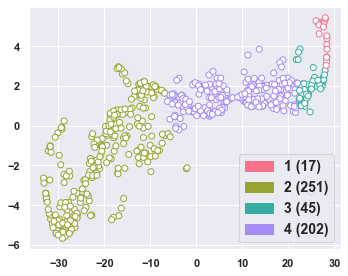

In [127]:
fig=plt.figure(figsize=(5,4))
size = len(all_HR)

plt.scatter(tsne_all_HR[0:size, 0], tsne_all_HR[0:size, 1], 
            edgecolors=[model_colors[i-1] for i in clusters],
            cmap='prism', c="w",  marker="o", label='Z')  

plt.tight_layout()
plt.legend(handles=handles[0:num_clusters], fontsize=legend_size, loc='best')


In [128]:
r1_f = np.load(path + 'Test_r1_F.npy')
r1_cf = np.load(path + 'Test_r1_CF.npy')

r0_f = np.load(path + 'Test_r0_F.npy')
r0_cf = np.load(path + 'Test_r0_CF.npy')

print("r1_f: ", r1_f.shape)
print("r1_cf: ", r1_cf.shape)

print("r0_f: ", r0_f.shape)
print("r0_cf: ", r0_cf.shape)

r1_f:  (60, 100)
r1_cf:  (455, 100)
r0_f:  (455, 100)
r0_cf:  (60, 100)


In [129]:
perp=50
tsne = TSNE(random_state=seed, perplexity=perp, verbose=1, n_components=2, init='pca', n_iter=5000)
r_factuals = np.concatenate((r1_f, r0_f), axis=0)
tsne_factuals = tsne.fit_transform(r_factuals)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 515 samples in 0.000s...
[t-SNE] Computed neighbors for 515 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 515 / 515
[t-SNE] Mean sigma: 0.029039
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.677704
[t-SNE] KL divergence after 1200 iterations: 0.680303


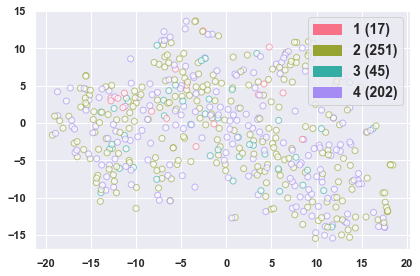

In [130]:

size = len(tsne_factuals)
plt.scatter(tsne_factuals[0:size, 0], tsne_factuals[0:size, 1], 
            edgecolors=[model_colors[i-1] for i in clusters],
            cmap='prism', c="w",  marker="o", label='$r$', alpha=0.6)  

plt.tight_layout()
plt.legend(handles=handles[0:num_clusters], fontsize=legend_size, loc='best')


## Median LogHarzard Ratio

25:  0.024 75:  1.916 50:  0.0 3


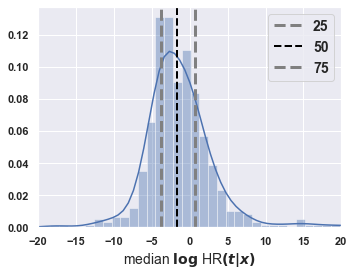

In [131]:
fig=plt.figure(figsize=(5,4))

perc_25 = np.round(np.percentile(all_HR_median, 25),2)
perc_50 = np.round(np.percentile(all_HR_median, 50),2)
perc_75 = np.round(np.percentile(all_HR_median, 75),2)

print("25: ", np.round(np.exp(perc_25), 3), "75: ",
      np.round(np.exp(perc_75), 3) , "50: ", np.round(np.exp(perc_50)), 3)

xlabel =  'median ' +'$\log$'  + ' ' +  'HR' + '$(t|x)$'
sns.distplot(all_HR_median)
plt.xlabel(xlabel ,  fontsize=fontsize)

plt.axvline(x=perc_25 ,color='grey', label='25', linestyle='--', lw=3)
plt.axvline(x=perc_50 ,color='black', label='50', linestyle='--', lw=2)
plt.axvline(x=perc_75 ,color='grey', label='75', linestyle='--', lw=3)
plt.tight_layout()
plt.xlim((-20, 20))
plt.legend(fontsize=legend_size, loc='best')


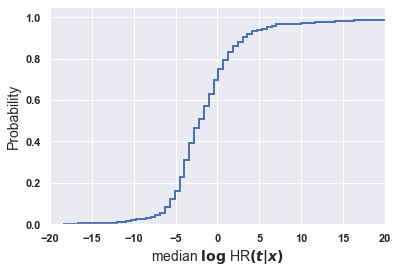

In [132]:
plt.hist(all_HR_median,cumulative=True, density=True, bins=100, histtype='step', linewidth=2)
#kwargs = {'cumulative': True}
#sns.distplot(all_HR_median, hist_kws=kwargs, kde_kws=kwargs)
plt.xlabel(xlabel ,  fontsize=fontsize)
plt.ylabel('Probability' ,  fontsize=fontsize)
if data == 'framingham':
    plt.xlim((-20, 20))
else:
    plt.xlim((-20, 3))

In [133]:
print("50",  np.round(np.percentile(all_HR_median, 50), 2))

50 -1.68


In [134]:
thresh = np.round(np.percentile(all_HR_median, 25), 2)
print("thresh: ", thresh)

print("positive: ", len(all_HR_median[all_HR_median < thresh ])/ len(all_HR_median))
positive = x0_x1_conc[all_HR_median < thresh]


thresh:  -3.75
positive:  0.2504854368932039


In [135]:
if data == 'framingham':
    end = 8
    positive[sub_covariates[0:8]].describe()
else:
    end = 12

positive[sub_covariates[0:end]].describe()


,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,55.558140,0.069767,29.326328,0.317829,202.147287,75.922481,0.116279,0.465116
std,9.412348,0.255748,4.800124,0.467448,40.368053,7.184632,0.321809,0.500726
min,35.000000,0.000000,20.777429,0.000000,118.000000,55.000000,0.000000,0.000000
25%,50.000000,0.000000,25.995640,0.000000,176.000000,71.000000,0.000000,0.000000
50%,54.000000,0.000000,28.835150,0.000000,196.000000,76.000000,0.000000,0.000000
75%,61.000000,0.000000,31.847777,1.000000,225.000000,80.000000,0.000000,1.000000
max,84.000000,1.000000,45.135681,1.000000,312.000000,100.000000,1.000000,1.000000


In [136]:
positive[sub_covariates[end:]].describe()

,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,102.201550,43.953488,0.007752,123.782946,0.170543,0.015504,0.038760,164.139535
std,34.450912,11.543979,0.088045,13.923879,0.377575,0.124027,0.193774,78.358625
min,75.000000,26.000000,0.000000,99.000000,0.000000,0.000000,0.000000,46.000000
25%,90.000000,35.000000,0.000000,114.000000,0.000000,0.000000,0.000000,119.000000
50%,95.000000,43.000000,0.000000,122.000000,0.000000,0.000000,0.000000,143.000000
75%,103.000000,50.000000,0.000000,131.000000,0.000000,0.000000,0.000000,200.000000
max,289.000000,95.000000,1.000000,170.000000,1.000000,1.000000,1.000000,468.000000


In [137]:
thresh = np.round(np.percentile(all_HR_median, 75), 2)
print("thresh: ", thresh)
print("negative", len(all_HR_median[all_HR_median > thresh])/ len(all_HR_median))
negative = x0_x1_conc[all_HR_median>thresh]

thresh:  0.65
negative 0.2504854368932039


In [138]:
negative[sub_covariates[0:end]].describe()

,age6,ascvd_hx6,bmi6,bpmeds6,chol5,dbp6,diab6,female
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,60.666667,0.139535,26.375823,0.286822,197.581395,71.627907,0.046512,0.604651
std,10.185263,0.347855,5.325558,0.454041,28.029197,11.657260,0.211411,0.490832
min,37.000000,0.000000,17.676632,0.000000,118.000000,49.000000,0.000000,0.000000
25%,53.000000,0.000000,22.687889,0.000000,180.000000,62.000000,0.000000,0.000000
50%,60.000000,0.000000,25.285077,0.000000,198.000000,70.000000,0.000000,1.000000
75%,69.000000,0.000000,29.230393,1.000000,217.000000,81.000000,0.000000,1.000000
max,78.000000,1.000000,45.992112,1.000000,290.000000,105.000000,1.000000,1.000000


In [139]:
negative[sub_covariates[end:]].describe()

,gluc5,hdl5,pad_hx6,sbp6,smoke6,stk_hx6,mi_hx6,trigly5
count,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000,129.000000
mean,96.023256,58.550388,0.054264,128.007752,0.217054,0.046512,0.054264,119.937984
std,16.391912,16.147253,0.227420,22.184417,0.413847,0.211411,0.227420,133.107261
min,48.000000,22.000000,0.000000,88.000000,0.000000,0.000000,0.000000,33.000000
25%,88.000000,49.000000,0.000000,111.000000,0.000000,0.000000,0.000000,63.000000
50%,95.000000,59.000000,0.000000,126.000000,0.000000,0.000000,0.000000,87.000000
75%,101.000000,69.000000,0.000000,140.000000,0.000000,0.000000,0.000000,109.000000
max,228.000000,101.000000,1.000000,214.000000,1.000000,1.000000,1.000000,1149.000000


In [140]:
print(np.log(0.54), np.log(0.8))

-0.616186139423817 -0.2231435513142097
